# Creating DataFrame

In [4]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

In [5]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050.'
html = requests.get(url).text
soup = BeautifulSoup(html,'lxml')
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [6]:
df_wiki = pd.read_html(str(wiki_table))
df_wiki = df_wiki[0].dropna(axis=0)
df_wiki = df_wiki[~df_wiki['Borough'].isin(['Not assigned'])]

In [7]:
df_new = df_wiki.groupby(['Postcode','Borough'], sort=False)['Neighbourhood'].apply(', '.join).reset_index()
df_new['Neighbourhood'] = np.where(df_new.Neighbourhood == 'Not assigned', df_new.Borough, df_new.Neighbourhood)

In [8]:
df_new.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


In [9]:
df_new.info

<bound method DataFrame.info of     Postcode           Borough  \
0        M3A        North York   
1        M4A        North York   
2        M5A  Downtown Toronto   
3        M6A        North York   
4        M7A  Downtown Toronto   
5        M9A         Etobicoke   
6        M1B       Scarborough   
7        M3B        North York   
8        M4B         East York   
9        M5B  Downtown Toronto   
10       M6B        North York   
11       M9B         Etobicoke   
12       M1C       Scarborough   
13       M3C        North York   
14       M4C         East York   
15       M5C  Downtown Toronto   
16       M6C              York   
17       M9C         Etobicoke   
18       M1E       Scarborough   
19       M4E      East Toronto   
20       M5E  Downtown Toronto   
21       M6E              York   
22       M1G       Scarborough   
23       M4G         East York   
24       M5G  Downtown Toronto   
25       M6G  Downtown Toronto   
26       M1H       Scarborough   
27       M2H    

In [10]:
df_new.shape
#df_new is the Toronto neiborhood data we are going to use from wiki website

(103, 3)

# Inserting Geographical Coordinates

In [11]:
import types
from botocore.client import Config
import ibm_boto3

# Combining two tables

In [12]:
df_coord=pd.read_csv('http://cocl.us/Geospatial_data')
df_coord.rename(columns={'Postal Code':'PostalCode'},inplace=True)
df_coord.head()
df_new1 = pd.merge(df_new, df_coord, left_on='Postcode', right_on='PostalCode',how='left')
df_new1.head()

,Postcode,Borough,Neighbourhood,PostalCode,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,M7A,43.662301,-79.389494


In [13]:
#check 'M5G'
df_new1.loc[df_new1['Postcode'] == 'M5G']

,Postcode,Borough,Neighbourhood,PostalCode,Latitude,Longitude
24,M5G,Downtown Toronto,Central Bay Street,M5G,43.657952,-79.387383


In [14]:
df_toronto=df_new1[['Postcode','Borough','Neighbourhood','Latitude','Longitude']]
df_toronto.shape

(103, 5)

In [15]:
df_toronto.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [16]:
#So I am going to wrap up what I have done above:
    #importing Toronto neighborhood data from wiki website provided by course;
    #importing geospatial coordinate data provided by course;
    #cleaning two datasets, the first one named as df_new, and the second one named as df_coord;
    #merging two dataset with left join and name the joined table as df_toronto

# Starting Exploring Neighbourhood

Now first explore one neighbour

1. define Foursquare version and credentials

2. explore the first neighbour

In [17]:
df_toronto.loc[0, 'Neighbourhood']

'Parkwoods'

In [18]:
neighborhood_latitude = df_toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


3.Get the top 100 venues that are Parkwoods within a radius of 500 meters

4.Create get request URL and get the response

In [20]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
results = requests.get(url).json()

In [21]:
results

{'meta': {'code': 200, 'requestId': '5e852e56d03993001b979d94'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114
2,TTC stop - 44 Valley Woods,Bus Stop,43.755402,-79.333741


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


# Now let's repeat above process to neighbourhood in Toronto 

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'], 
                             latitudes=df_toronto['Latitude'], 
                             longitudes=df_toronto['Longitude'])


Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West,

In [27]:
#checking the above dataframe and its size
print(toronto_venues.shape)
toronto_venues.head()

(2206, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


1. count venues for each neighbour and see the numbers of venues in each neighbor

In [28]:
toronto_venues.groupby('Neighborhood').count()['Venue'].sort_values(ascending=False)


Neighborhood
Adelaide, King, Richmond                                                                                                                  100
First Canadian Place, Underground city                                                                                                    100
St. James Town                                                                                                                            100
Commerce Court, Victoria Hotel                                                                                                            100
Harbourfront East, Toronto Islands, Union Station                                                                                         100
Design Exchange, Toronto Dominion Centre                                                                                                  100
Ryerson, Garden District                                                                                                               

2. do one hot coding

In [29]:
# one hot encoding
df_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()
toronto_venuelist = df_onehot.groupby('Neighborhood').mean().reset_index()

In [30]:
df_onehot.shape

(2206, 267)

In [31]:
toronto_venuelist.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.01
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00


3. do some statistical analysis on df_onehot

In [32]:
df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
df_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.020000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.01
1,Agincourt,0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Bayview Village,0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,Berczy Park,0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.017857,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,...,0.00000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [33]:
df_grouped.shape

(98, 267)

In [34]:
df_grouped.info

<bound method DataFrame.info of                                          Neighborhood  Yoga Studio  \
0                            Adelaide, King, Richmond     0.000000   
1                                           Agincourt     0.000000   
2   Agincourt North, L'Amoreaux East, Milliken, St...     0.000000   
3   Albion Gardens, Beaumond Heights, Humbergate, ...     0.000000   
4                              Alderwood, Long Branch     0.000000   
5     Bathurst Manor, Downsview North, Wilson Heights     0.000000   
6                                     Bayview Village     0.000000   
7                   Bedford Park, Lawrence Manor East     0.000000   
8                                         Berczy Park     0.000000   
9                         Birch Cliff, Cliffside West     0.000000   
10  Bloordale Gardens, Eringate, Markland Wood, Ol...     0.000000   
11       Brockton, Exhibition Place, Parkdale Village     0.000000   
12  Business Reply Mail Processing Centre 969 Eastern     

4. look for top 3 freq of venues in each neighbor

In [35]:
num_top_venues = 3

for hood in df_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
         venue  freq
0  Coffee Shop  0.06
1   Restaurant  0.06
2         Café  0.05


----Agincourt----
                       venue  freq
0             Clothing Store  0.25
1  Latin American Restaurant  0.25
2                     Lounge  0.25


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
         venue  freq
0         Park   0.5
1   Playground   0.5
2  Yoga Studio   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                 venue  freq
0        Grocery Store  0.22
1             Pharmacy  0.11
2  Fried Chicken Joint  0.11


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.22
1  Athletics & Sports  0.11
2            Pharmacy  0.11


----Bathurst Manor, Downsview North, Wilson Heights----
         venue  freq
0  Coffee Shop  0.10
1         Bank  0.10
2  Pizza Place  0.05


----Bayview Village----
                venue  

# Now Conduct Clustering Analysis on Toronto Neighborhood

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [57]:
import numpy as np
#get most 10 common venues in each area
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Café,Thai Restaurant,Bakery,Bar,Lounge,Juice Bar,Steakhouse,Concert Hall
1,Agincourt,Latin American Restaurant,Breakfast Spot,Clothing Store,Lounge,Eastern European Restaurant,Electronics Store,Dumpling Restaurant,Empanada Restaurant,Dessert Shop,Drugstore
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Sandwich Place,Liquor Store,Fast Food Restaurant,Pizza Place,Pharmacy,Donut Shop,Department Store
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Skating Rink,Athletics & Sports,Pub,Gym,Comic Shop,Deli / Bodega


KMEANS clustering

Conducting Elbow method to find best K

In [58]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [59]:
toronto_venuelist_clustering = toronto_venuelist.drop('Neighborhood', 1)

In [60]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_venuelist_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

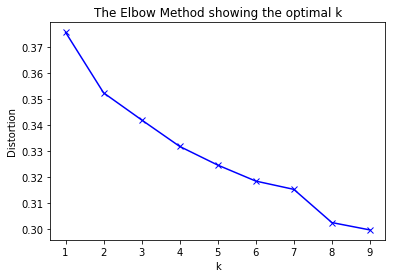

In [61]:
distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(toronto_venuelist_clustering)
    kmeans.fit(toronto_venuelist_clustering)
    distortions.append(sum(np.min(cdist(toronto_venuelist_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / toronto_venuelist_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

When K increases, the centroids are closer to the clusters centroids.

The improvements will decline, at some point rapidly, creating the elbow shape.

That point is the optimal value for K. In the image above, K=8

In [70]:
# set number of clusters
kclusters = 8

toronto_venuelist_clustering = toronto_venuelist.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_venuelist_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 6, 4, 0, 4, 4, 4, 4, 4], dtype=int32)

In [71]:
neighborhoods_venues_sorted.insert(0, 'Clusters', kmeans.labels_)

ValueError: cannot insert Clusters, already exists

Merge result tables

In [72]:
df_toronto_merged = df_toronto

df_toronto_merged = df_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

df_toronto_merged.dropna(axis=0,inplace = True)
df_toronto_merged['Clusters'] = df_toronto_merged['Clusters'].astype('int')

df_toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,6,Park,Bus Stop,Food & Drink Shop,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Ethiopian Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,Intersection,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,4,Coffee Shop,Park,Pub,Bakery,Theater,Restaurant,Breakfast Spot,Café,Mexican Restaurant,Dessert Shop
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,4,Clothing Store,Furniture / Home Store,Women's Store,Coffee Shop,Miscellaneous Shop,Boutique,Sporting Goods Shop,Event Space,Vietnamese Restaurant,Gift Shop
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,4,Coffee Shop,Yoga Studio,Distribution Center,Mexican Restaurant,Bank,Bar,Diner,Discount Store,Beer Bar,Hobby Shop
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,7,Fast Food Restaurant,Women's Store,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
7,M3B,North York,Don Mills North,43.745906,-79.352188,4,Café,Baseball Field,Gym / Fitness Center,Caribbean Restaurant,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,0,Pizza Place,Fast Food Restaurant,Gastropub,Café,Athletics & Sports,Intersection,Bus Line,Bank,Pharmacy,Pet Store
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,4,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Ramen Restaurant,Pizza Place,Fast Food Restaurant,Electronics Store
10,M6B,North York,Glencairn,43.709577,-79.445073,0,Park,Pub,Pizza Place,Japanese Restaurant,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


Check clusters for further analysis

In [73]:
df_toronto_merged.groupby('Clusters')['Neighbourhood'].count()

Clusters
0     8
1     1
2     1
3     1
4    74
5     1
6    11
7     1
Name: Neighbourhood, dtype: int64

Now let's check cluster 0, 4 and 6 to see which is better for the location

In [79]:
df_toronto_merged.loc[df_toronto_merged['Clusters'] == 0, df_toronto_merged.columns[[1] + list(range(5, df_toronto_merged.shape[1]))]]

,Borough,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Intersection,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
8,East York,0,Pizza Place,Fast Food Restaurant,Gastropub,Café,Athletics & Sports,Intersection,Bus Line,Bank,Pharmacy,Pet Store
10,North York,0,Park,Pub,Pizza Place,Japanese Restaurant,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
50,North York,0,Empanada Restaurant,Pizza Place,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
63,York,0,Pizza Place,Bus Line,Caribbean Restaurant,Brewery,Women's Store,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
70,Etobicoke,0,Pizza Place,Middle Eastern Restaurant,Chinese Restaurant,Coffee Shop,Discount Store,Sandwich Place,Intersection,Dessert Shop,Dim Sum Restaurant,Diner
77,Etobicoke,0,Park,Bus Line,Pizza Place,Sandwich Place,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
93,Etobicoke,0,Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Skating Rink,Athletics & Sports,Pub,Gym,Comic Shop,Deli / Bodega


In [80]:
df_toronto_merged.loc[df_toronto_merged['Clusters'] == 4, df_toronto_merged.columns[[1] + list(range(5, df_toronto_merged.shape[1]))]]

,Borough,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,4,Coffee Shop,Park,Pub,Bakery,Theater,Restaurant,Breakfast Spot,Café,Mexican Restaurant,Dessert Shop
3,North York,4,Clothing Store,Furniture / Home Store,Women's Store,Coffee Shop,Miscellaneous Shop,Boutique,Sporting Goods Shop,Event Space,Vietnamese Restaurant,Gift Shop
4,Downtown Toronto,4,Coffee Shop,Yoga Studio,Distribution Center,Mexican Restaurant,Bank,Bar,Diner,Discount Store,Beer Bar,Hobby Shop
7,North York,4,Café,Baseball Field,Gym / Fitness Center,Caribbean Restaurant,Japanese Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
9,Downtown Toronto,4,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Ramen Restaurant,Pizza Place,Fast Food Restaurant,Electronics Store
13,North York,4,Beer Store,Gym,Restaurant,Coffee Shop,Italian Restaurant,Dim Sum Restaurant,Discount Store,Sporting Goods Shop,Asian Restaurant,Chinese Restaurant
14,East York,4,Skating Rink,Dance Studio,Spa,Diner,Curling Ice,Athletics & Sports,Bus Stop,Cosmetics Shop,Beer Store,Pharmacy
15,Downtown Toronto,4,Coffee Shop,Italian Restaurant,Café,Restaurant,Diner,American Restaurant,Cosmetics Shop,Bakery,Breakfast Spot,Cocktail Bar
16,York,4,Trail,Field,Hockey Arena,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
17,Etobicoke,4,Cosmetics Shop,Café,Pet Store,Pizza Place,Coffee Shop,Beer Store,Convenience Store,Liquor Store,Doner Restaurant,Diner


In [81]:
df_toronto_merged.loc[df_toronto_merged['Clusters'] == 6, df_toronto_merged.columns[[1] + list(range(5, df_toronto_merged.shape[1]))]]

,Borough,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,6,Park,Bus Stop,Food & Drink Shop,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Ethiopian Restaurant
21,York,6,Park,Market,Women's Store,Gluten-free Restaurant,Gift Shop,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
35,East York,6,Park,Convenience Store,Coffee Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
40,North York,6,Park,Airport,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
49,North York,6,Park,Bakery,Construction & Landscaping,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
64,York,6,Park,Convenience Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega,Doner Restaurant
66,North York,6,Park,Bank,Convenience Store,Bar,Women's Store,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run
85,Scarborough,6,Park,Playground,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
91,Downtown Toronto,6,Park,Playground,Trail,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Electronics Store,Donut Shop,Doner Restaurant,Dance Studio
98,Etobicoke,6,Park,River,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Ethiopian Restaurant,Dog Run
